# **Downloading and extracting data**

# **Extracting, Exploring and Preprocessing the data**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
train_dir = '../data'

In [4]:
train_dataset = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.2,
    subset='training',
    seed=42
)

Found 700 files belonging to 3 classes.
Using 560 files for training.


In [5]:
validation_dataset = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    image_size=(128, 128),
    batch_size=32,
    validation_split=0.2,
    subset='validation',
    seed=42
)

Found 700 files belonging to 3 classes.
Using 140 files for validation.


In [6]:
class_names = train_dataset.class_names
class_names

['Ashok', 'Priynash', 'Vrajesh']

In [7]:
for image in train_dataset:
    print(image[0].shape)
    break

(32, 128, 128, 3)


In [8]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

In [9]:
def augment(image, label):
    return data_augmentation(image, training=True), label

In [10]:
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [11]:
train_dataset = train_dataset.map(normalize)
validation_dataset = validation_dataset.map(normalize)

In [12]:
train_dataset = train_dataset.map(augment)
validation_dataset = validation_dataset.map(augment)

# **Building CNN Model**

## **Creating base model using MobileNet V2**

In [13]:
base_model = tf.keras.applications.ResNet50(input_shape=(128,128,3),
                                               include_top=False,
                                               weights='imagenet')

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


In [ ]:
base_model.summary()

In [15]:
print(len(base_model.layers))

175


In [ ]:
# Freezing the model
base_model.trainable = False
base_layer_count = len(base_model.layers)
base_model.summary()

In [17]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation="softmax")

## **Architecture of Model**

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Resizing(128, 128, input_shape=(180, 180, 3)),
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    prediction_layer
])

C:\Users\Ashok Bhatt\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
print(len(base_model.layers))
print(len(model.layers))

175
11


## **Compiling and training model**

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,661,123 (155.11 MB)

 Trainable params: 17,007,875 (64.88 MB)

 Non-trainable params: 23,653,248 (90.23 MB)

In [22]:
checkpoint_acc = tf.keras.callbacks.ModelCheckpoint(filepath='./weights/best_weights_acc.keras',
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True,
                                 mode='max')

checkpoint_loss = tf.keras.callbacks.ModelCheckpoint(filepath='./weights/best_weights_loss.keras',
                                  monitor='val_loss',
                                  verbose=1,
                                  save_best_only=True,
                                  mode='min')

In [23]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=15)
history = model.fit(train_dataset, epochs=50, validation_data=validation_dataset, callbacks=[early_stopping, checkpoint_acc, checkpoint_loss])

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7079 - loss: 0.6528
Epoch 1: val_accuracy improved from -inf to 0.37857, saving model to ./weights/best_weights_acc.keras

Epoch 1: val_loss improved from inf to 10.45760, saving model to ./weights/best_weights_loss.keras
18/18 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7151 - loss: 0.6407 - val_accuracy: 0.3786 - val_loss: 10.4576
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9458 - loss: 0.1831
Epoch 2: val_accuracy did not improve from 0.37857

Epoch 2: val_loss did not improve from 10.45760
18/18 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.9453 - loss: 0.1830 - val_accuracy: 0.3786 - val_loss: 20.5005
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9537 - loss: 0.1443
Epoch 3: val_accuracy did not improve from 0.37857

Epoch 3: val_loss did not improve from 10.45760
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9544 - loss: 0.1428 - val_accuracy: 0.3786 - val_loss: 19.7752
E

Loading Saved Weights

In [24]:
model.load_weights('./weights/best_weights_acc.keras')
model.load_weights('./weights/best_weights_loss.keras')

In [25]:
training_accuaracies = history.history['accuracy']
validation_accuaracies = history.history['val_accuracy']
training_losses = history.history['loss']
validation_losses = history.history['val_loss']

In [31]:
loss, accuracy = model.evaluate(train_dataset)

18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 869ms/step - accuracy: 1.0000 - loss: 0.0027


In [32]:
print(accuracy)
print(loss)

1.0
0.0023857555352151394


In [26]:
validate_loss, validate_accuracy = model.evaluate(validation_dataset)

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 1.0000 - loss: 5.1487e-04


In [27]:
print(validate_accuracy)
print(validate_loss)

1.0
0.0005911144544370472


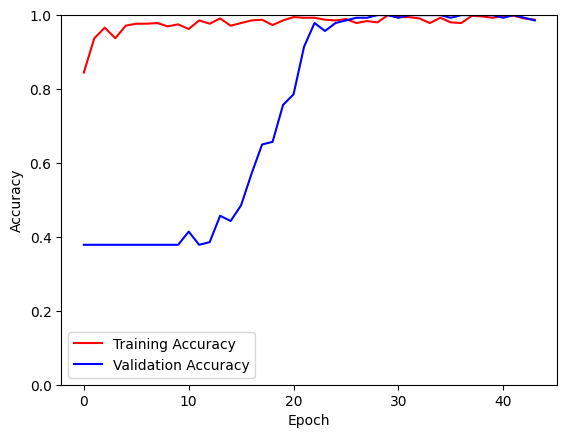

In [28]:
plt.plot(training_accuaracies, label='Training Accuracy', color='red')
plt.plot(validation_accuaracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend()

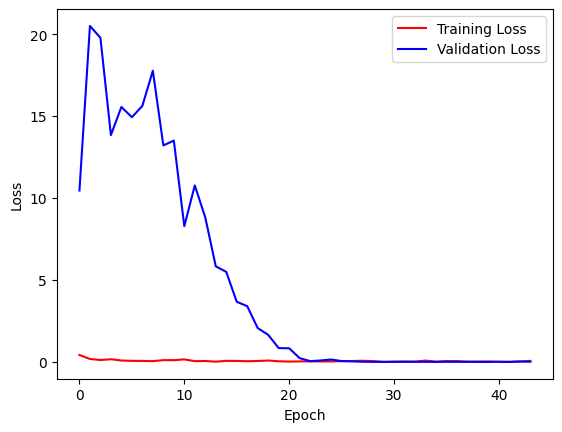

In [29]:
plt.plot(training_losses, label='Training Loss', color='red')
plt.plot(validation_losses, label='Validation Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [30]:
model.save('../server/models/student_recognition.keras')